# LSTM vs GRU Comparison

Head-to-head comparison using identical hyperparameters, data, and architecture.
The only difference is the recurrent cell type (LSTM vs GRU).

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, LSTM, Input
from keras.utils import pad_sequences
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [12]:
df = pd.read_csv('../data/asfp_cleaned_features.csv')
print(f"Shape: {df.shape}")

Shape: (23201, 15)


In [13]:
#########################
#### Hyperparameters ####
#########################

feature_cols = ['water_temp', 'ph', 'ec', 'do', 'dt_seconds', 'segment', 'hour', 'dayofweek', 'month', 'water_temp_roll1h_mean', 'ph_roll1h_mean', 'ec_roll1h_mean', 'do_roll1h_mean']
input_features = ['water_temp', 'ph', 'ec', 'do', 'hour']
output_features = ['water_temp', 'ph', 'ec', 'do']

n_inputs = len(input_features)
n_outputs = len(output_features)

layer_1_units = 64
layer_2_units = 36

dropout_rate = 0.2
learning_rate = 0.01

batch_size = 500
validation_split = 0.05

seq_length = 10
pred_horizon = 12

unit_labels = {'water_temp': '\u00b0C', 'ph': 'pH', 'ec': '\u00b5S/cm', 'do': 'mg/L'}

In [14]:
all_results = []

for sensor_id in [1, 2]:
    print(f"\n{'='*60}")
    print(f"  SENSOR {sensor_id}")
    print(f"{'='*60}")

    #### Split & Scale ####
    df_sub = df[df['sensor'] == sensor_id]
    X_train, X_test = train_test_split(df_sub, test_size=0.2, shuffle=False)
    df_train = X_train.reset_index()
    df_test = X_test.reset_index()

    output_scaler = MinMaxScaler()
    output_scaler.fit(df_train[output_features])

    scaler = MinMaxScaler()
    df_train[feature_cols] = scaler.fit_transform(df_train[feature_cols])
    df_test[feature_cols] = scaler.transform(df_test[feature_cols])

    #### Build Sequences ####
    seq_arrays = []
    seq_labels = []
    for i in range(len(df_train) - seq_length - pred_horizon):
        seq_arrays.append(df_train[input_features].iloc[i:i+seq_length].values)
        seq_labels.append(df_train[output_features].iloc[i+seq_length+pred_horizon].values)
    seq_arrays = np.array(seq_arrays)
    seq_labels = np.array(seq_labels)

    test_arrays = []
    test_labels = []
    for i in range(2, len(df_test) - pred_horizon):
        start_idx = max(0, i - seq_length)
        test_arrays.append(df_test[input_features].iloc[start_idx:i].values)
        test_labels.append(df_test[output_features].iloc[i + pred_horizon].values)
    test_arrays = pad_sequences(test_arrays, maxlen=seq_length, dtype='float32', padding='pre')
    test_labels = np.array(test_labels, dtype=np.float32)

    #### Train both models ####
    for cell_type, LayerClass in [('GRU', GRU), ('LSTM', LSTM)]:
        print(f"\n--- {cell_type} ---")

        model = Sequential(name=f'{cell_type.lower()}_sensor{sensor_id}')
        model.add(Input(shape=(seq_length, n_inputs)))
        model.add(LayerClass(units=layer_1_units, return_sequences=True))
        model.add(Dropout(dropout_rate))
        model.add(LayerClass(units=layer_2_units, return_sequences=False))
        model.add(Dropout(dropout_rate))
        model.add(Dense(units=n_outputs))
        model.compile(optimizer=Adam(learning_rate), loss='mse', metrics=['mse'])

        print(f'Parameters: {model.count_params():,}')

        history = model.fit(
            seq_arrays, seq_labels,
            epochs=100, batch_size=batch_size, validation_split=validation_split, verbose=0,
            callbacks=[EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)]
        )

        scores = model.evaluate(test_arrays, test_labels, verbose=0)
        y_pred = model.predict(test_arrays, verbose=0)

        y_pred_orig = output_scaler.inverse_transform(y_pred)
        y_true_orig = output_scaler.inverse_transform(test_labels)

        per_feat_mse = {}
        for i, feat in enumerate(output_features):
            mse = np.nanmean((y_true_orig[:, i] - y_pred_orig[:, i]) ** 2)
            per_feat_mse[feat] = mse

        all_results.append({
            'sensor': sensor_id,
            'model': cell_type,
            'params': model.count_params(),
            'epochs': len(history.history['loss']),
            'test_mse_scaled': scores[1],
            **{f'{f}_mse': per_feat_mse[f] for f in output_features},
            **{f'{f}_rmse': np.sqrt(per_feat_mse[f]) for f in output_features},
        })

        print(f'Epochs: {len(history.history["loss"])}, Test MSE (scaled): {scores[1]:.6f}')
        for feat in output_features:
            print(f'  {feat}: RMSE = {np.sqrt(per_feat_mse[feat]):.4f} {unit_labels[feat]}')

results_df = pd.DataFrame(all_results)


  SENSOR 1

--- GRU ---
Parameters: 24,796
Epochs: 58, Test MSE (scaled): 0.007951
  water_temp: RMSE = 0.4213 °C
  ph: RMSE = 0.3410 pH
  ec: RMSE = 0.4182 µS/cm
  do: RMSE = 1.3537 mg/L

--- LSTM ---
Parameters: 32,612
Epochs: 37, Test MSE (scaled): 0.009545
  water_temp: RMSE = 0.4227 °C
  ph: RMSE = 0.3397 pH
  ec: RMSE = 0.4730 µS/cm
  do: RMSE = 1.5781 mg/L

  SENSOR 2

--- GRU ---
Parameters: 24,796
Epochs: 14, Test MSE (scaled): 0.001069
  water_temp: RMSE = 0.2068 °C
  ph: RMSE = 0.0888 pH
  ec: RMSE = 0.1840 µS/cm
  do: RMSE = 0.1781 mg/L

--- LSTM ---
Parameters: 32,612
Epochs: 31, Test MSE (scaled): 0.001231
  water_temp: RMSE = 0.2354 °C
  ph: RMSE = 0.0950 pH
  ec: RMSE = 0.1950 µS/cm
  do: RMSE = 0.1825 mg/L



=== LSTM vs GRU Comparison ===
 Sensor Model  Parameters  Epochs  Test MSE (scaled)  water_temp RMSE (°C)  ph RMSE (pH)  ec RMSE (µS/cm)  do RMSE (mg/L)
      1   GRU       24796      58           0.007951              0.421291      0.341007         0.418165        1.353720
      1  LSTM       32612      37           0.009545              0.422693      0.339732         0.473035        1.578137
      2   GRU       24796      14           0.001069              0.206817      0.088795         0.183991        0.178091
      2  LSTM       32612      31           0.001231              0.235385      0.095029         0.194978        0.182536


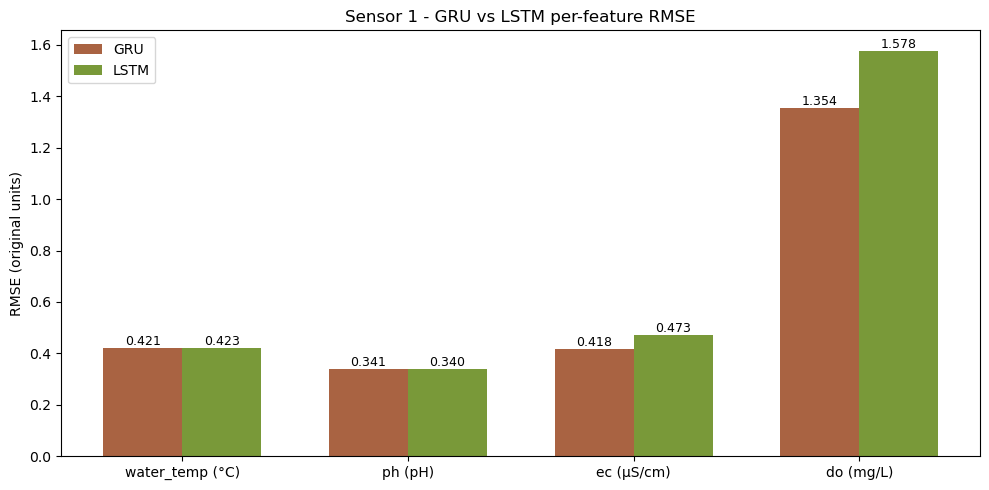

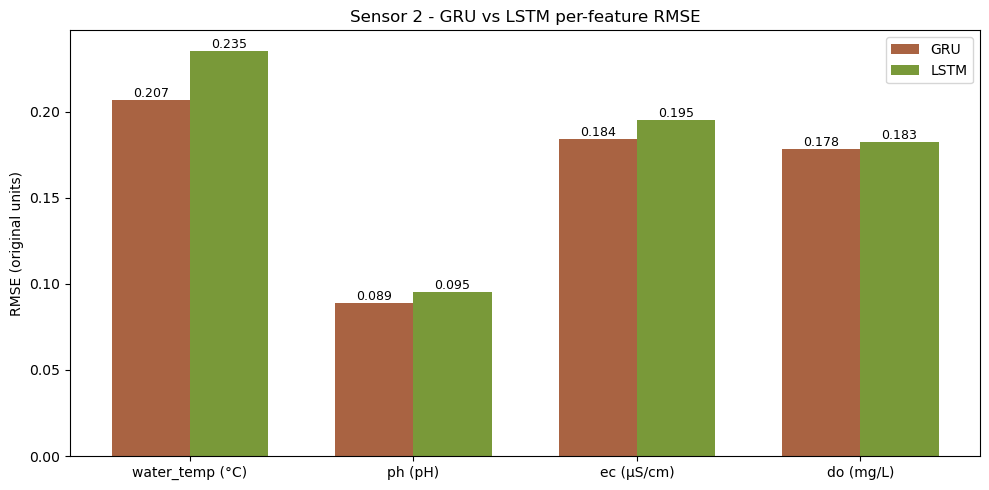

In [15]:
##################################
#### Comparison Summary Table ####
##################################

display_cols = ['sensor', 'model', 'params', 'epochs', 'test_mse_scaled']
rmse_cols = [f'{f}_rmse' for f in output_features]

summary = results_df[display_cols + rmse_cols].copy()
summary.columns = ['Sensor', 'Model', 'Parameters', 'Epochs', 'Test MSE (scaled)'] + [f'{f} RMSE ({unit_labels[f]})' for f in output_features]

print("\n=== LSTM vs GRU Comparison ===")
print(summary.to_string(index=False))

# Bar chart comparison
for sensor_id in [1, 2]:
    sensor_data = results_df[results_df['sensor'] == sensor_id]
    x = np.arange(len(output_features))
    width = 0.35

    gru_rmse = [sensor_data[sensor_data['model'] == 'GRU'][f'{f}_rmse'].values[0] for f in output_features]
    lstm_rmse = [sensor_data[sensor_data['model'] == 'LSTM'][f'{f}_rmse'].values[0] for f in output_features]

    fig, ax = plt.subplots(figsize=(10, 5))
    bars1 = ax.bar(x - width/2, gru_rmse, width, label='GRU', color='#A0522D', alpha=0.9)
    bars2 = ax.bar(x + width/2, lstm_rmse, width, label='LSTM', color='#6B8E23', alpha=0.9)

    ax.set_ylabel('RMSE (original units)')
    ax.set_title(f'Sensor {sensor_id} - GRU vs LSTM per-feature RMSE')
    ax.set_xticks(x)
    ax.set_xticklabels([f'{f} ({unit_labels[f]})' for f in output_features])
    ax.legend()

    # Add value labels on bars
    for bar in bars1:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=9)
    for bar in bars2:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig(f'../figures/gru_vs_lstm_sensor{sensor_id}.png', dpi=150, bbox_inches='tight')
    plt.show()